In [2]:
!pip install  pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 2.9 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425350 sha256=e83c7ee5c6af4ae4f8ae1257ece14867c9a516935acb81450387590c59bbaa63
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum
from pyspark.sql.functions import *


In [4]:
spark = SparkSession.builder \
    .master('local[1]') \
    .appName("Data Preparation with PySpark") \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/08 07:29:28 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
df=spark.read.csv("/kaggle/input/new-york-city-airbnb-open-data/AB_NYC_2019.csv")

In [6]:
df.show(5)


+----+--------------------+-------+-----------+-------------------+-------------+--------+---------+---------------+-----+--------------+-----------------+-----------+-----------------+--------------------+----------------+
| _c0|                 _c1|    _c2|        _c3|                _c4|          _c5|     _c6|      _c7|            _c8|  _c9|          _c10|             _c11|       _c12|             _c13|                _c14|            _c15|
+----+--------------------+-------+-----------+-------------------+-------------+--------+---------+---------------+-----+--------------+-----------------+-----------+-----------------+--------------------+----------------+
|  id|                name|host_id|  host_name|neighbourhood_group|neighbourhood|latitude|longitude|      room_type|price|minimum_nights|number_of_reviews|last_review|reviews_per_month|calculated_host_l...|availability_365|
|2539|Clean & quiet apt...|   2787|       John|           Brooklyn|   Kensington|40.64749|-73.97237|   P

In [7]:
df.describe()


DataFrame[summary: string, _c0: string, _c1: string, _c2: string, _c3: string, _c4: string, _c5: string, _c6: string, _c7: string, _c8: string, _c9: string, _c10: string, _c11: string, _c12: string, _c13: string, _c14: string, _c15: string]

In [8]:
df.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- _c1: string (nullable = true)
 |-- _c2: string (nullable = true)
 |-- _c3: string (nullable = true)
 |-- _c4: string (nullable = true)
 |-- _c5: string (nullable = true)
 |-- _c6: string (nullable = true)
 |-- _c7: string (nullable = true)
 |-- _c8: string (nullable = true)
 |-- _c9: string (nullable = true)
 |-- _c10: string (nullable = true)
 |-- _c11: string (nullable = true)
 |-- _c12: string (nullable = true)
 |-- _c13: string (nullable = true)
 |-- _c14: string (nullable = true)
 |-- _c15: string (nullable = true)



In [9]:
row_count = df.count()

print("Number of rows:", row_count)

Number of rows: 49080


**Check For Missing Values** 

Pourcentage of missing value in each column

In [110]:
missing_counts = df.agg(*[
    (1 - (sum(col(c).isNotNull().cast("int")) / df.count())).alias(c)
    for c in df.columns
])

missing_counts.show()


+---+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+------------------+--------------------+--------------------+
|_c0|                 _c1|                 _c2|                 _c3|                 _c4|                 _c5|                 _c6|                 _c7|                 _c8|                 _c9|                _c10|                _c11|              _c12|              _c13|                _c14|                _c15|
+---+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+------------------+--------------------+--------------------+
|0.0|6.519967400162585E-4|0.003769356153219272|0.

**Missing Values per column**

In [228]:
columns = df.columns

# Filtre is a transformation
null_counts = [df.filter(col(c).isNull()).count() for c in columns]

null_counts_df = spark.createDataFrame([(columns[i], null_counts[i]) for i in range(len(columns))], ["Column", "Null Count"])

null_counts_df.show()

+------+----------+
|Column|Null Count|
+------+----------+
|   _c0|         0|
|   _c1|        32|
|   _c2|       185|
|   _c3|       206|
|   _c4|       185|
|   _c5|       185|
|   _c6|       185|
|   _c7|       185|
|   _c8|       185|
|   _c9|       185|
|  _c10|       185|
|  _c11|       205|
|  _c12|     10234|
|  _c13|     10215|
|  _c14|       187|
|  _c15|       342|
+------+----------+



**Since we have 49,080 rows, we can drop the rows with a nan count of under 500. However, for columns like c12 and c13, we need to apply a different technique(replace by the mean).**

In [112]:
print(df.columns)

['_c0', '_c1', '_c2', '_c3', '_c4', '_c5', '_c6', '_c7', '_c8', '_c9', '_c10', '_c11', '_c12', '_c13', '_c14', '_c15']


In [7]:
columns_to_dropna=['_c0', '_c1', '_c2', '_c3', '_c4', '_c5', '_c6', '_c7', '_c8', '_c9', '_c10', '_c11', '_c14', '_c15']
df=df.dropna(subset=columns_to_dropna)

columns_to_fillna=['_c12', '_c13']
mean_values = df.select(*(mean(col(c)).alias(c) for c in columns_to_fillna)).collect()[0].asDict()#we add [0] because collect return a list


# Fill missing values with the calculated means
df = df.fillna(mean_values, subset=columns_to_fillna)


In [8]:
columns = df.columns
target=df.select('_c9')
# Filtre is a transformation
null_counts = [df.filter(col(c).isNull()).count() for c in columns]

#Display the result
null_counts_df = spark.createDataFrame([(columns[i], null_counts[i]) for i in range(len(columns))], ["Column", "Null Count"])

null_counts_df.show()

+------+----------+
|Column|Null Count|
+------+----------+
|   _c0|         0|
|   _c1|         0|
|   _c2|         0|
|   _c3|         0|
|   _c4|         0|
|   _c5|         0|
|   _c6|         0|
|   _c7|         0|
|   _c8|         0|
|   _c9|         0|
|  _c10|         0|
|  _c11|         0|
|  _c12|         0|
|  _c13|         0|
|  _c14|         0|
|  _c15|         0|
+------+----------+



In [57]:
print(df.first())

Row(_c0='id', _c1='name', _c2='host_id', _c3='host_name', _c4='neighbourhood_group', _c5='neighbourhood', _c6='latitude', _c7='longitude', _c8='room_type', _c9='price', _c10='minimum_nights', _c11='number_of_reviews', _c12='last_review', _c13='reviews_per_month', _c14='calculated_host_listings_count', _c15='availability_365')


In [58]:
print(df.head(15000)[1200])

Row(_c0='512775', _c1='The Cottage / 1500 sqft. of Privacy', _c2='2396295', _c3='Richard', _c4='Queens', _c5='Long Island City', _c6='40.75296', _c7='-73.93716', _c8='Entire home/apt', _c9='350', _c10='2', _c11='182', _c12='2019-06-11', _c13='2.20', _c14='1', _c15='272')


In [59]:

mode_values = []

for column in df.columns:
    mode_result = df.groupBy(column).agg(count(column).alias('count')).sort(desc('count')).limit(1)
    
    mode_value = mode_result.collect()[0][0]
    
    mode_values.append((column, mode_value))

for column, mode_value in mode_values:
    print(f"Column: {column}, Mode: {mode_value}")


Column: _c0, Mode: 16974
Column: _c1, Mode: Hillside Hotel
Column: _c2, Mode: 219517861
Column: _c3, Mode: Michael
Column: _c4, Mode: Manhattan
Column: _c5, Mode: Williamsburg
Column: _c6, Mode: 40.71813
Column: _c7, Mode: -73.95677
Column: _c8, Mode: Entire home/apt
Column: _c9, Mode: 100
Column: _c10, Mode: 1
Column: _c11, Mode: 0
Column: _c12, Mode: 5.436951428571429
Column: _c13, Mode: 1.3697830864293556
Column: _c14, Mode: 1
Column: _c15, Mode: 0


In [9]:
numerical_columns = [col for col, data_type in df.dtypes if data_type in ['int', 'double']]
print(numerical_columns)

[]


In [61]:
"""for column in df.columns:
    value_counts = df.groupBy(column).count().orderBy(col("count").desc())
    value_counts.show(truncate=False)"""

'for column in df.columns:\n    value_counts = df.groupBy(column).count().orderBy(col("count").desc())\n    value_counts.show(truncate=False)'

In [12]:
distinct_counts = [countDistinct(col(column)).alias(column) for column in df.columns]
df.agg(*distinct_counts).show()

+-----+-----+-----+-----+---+---+-----+-----+---+---+----+----+----+----+----+----+
|  _c0|  _c1|  _c2|  _c3|_c4|_c5|  _c6|  _c7|_c8|_c9|_c10|_c11|_c12|_c13|_c14|_c15|
+-----+-----+-----+-----+---+---+-----+-----+---+---+----+----+----+----+----+----+
|48700|47727|37333|11424| 13|226|19008|14690| 11|679| 112| 396|1773| 952|  54| 367|
+-----+-----+-----+-----+---+---+-----+-----+---+---+----+----+----+----+----+----+



In [13]:
for column in ['_c0',  '_c2', '_c6', '_c7', '_c9', '_c10', '_c11', '_c13', '_c14', '_c15']:
    df = df.withColumn(column, col(column).cast("int"))

In [10]:
from pyspark.ml.feature import StringIndexer

columns_to_encode = ['_c1', '_c3', '_c4', '_c5', '_c8', '_c12']

indexers = [StringIndexer(inputCol=column, outputCol=column + "_index").fit(df) for column in columns_to_encode]

# Apply the label encoding transformations to the DataFrame
for indexer in indexers:
    df = indexer.transform(df)



In [11]:
numerical_columns = [col for col, data_type in df.dtypes if data_type in ['int', 'double']]
print(numerical_columns)

['_c1_index', '_c3_index', '_c4_index', '_c5_index', '_c8_index', '_c12_index']


train=df
train.columns

In [12]:
train=df
train=train.drop(*['_c1', '_c3', '_c4', '_c5', '_c8', '_c12'])

In [13]:
train.first()

23/10/08 07:30:28 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB


Row(_c0='id', _c2='host_id', _c6='latitude', _c7='longitude', _c9='price', _c10='minimum_nights', _c11='number_of_reviews', _c13='reviews_per_month', _c14='calculated_host_listings_count', _c15='availability_365', _c1_index=46989.0, _c3_index=11379.0, _c4_index=12.0, _c5_index=225.0, _c8_index=10.0, _c12_index=1772.0)

In [14]:
train = train.filter(df["_c1"] != df.first()["_c1"])


23/10/08 07:30:31 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB


In [15]:
train.show()

+----+-----+--------+---------+---+----+----+------------------+----+----+---------+---------+---------+---------+---------+----------+
| _c0|  _c2|     _c6|      _c7|_c9|_c10|_c11|              _c13|_c14|_c15|_c1_index|_c3_index|_c4_index|_c5_index|_c8_index|_c12_index|
+----+-----+--------+---------+---+----+----+------------------+----+----+---------+---------+---------+---------+---------+----------+
|2539| 2787|40.64749|-73.97237|149|   1|   9|              0.21|   6| 365|  12859.0|      3.0|      1.0|     52.0|      1.0|     714.0|
|2595| 2845|40.75362|-73.98377|225|   1|  45|              0.38|   2| 355|  37456.0|     17.0|      0.0|      9.0|      0.0|      58.0|
|3647| 4632|40.80902| -73.9419|150|   3|   0|1.3697830864293556|   1| 365|  43457.0|    633.0|      0.0|      2.0|      1.0|       0.0|
|3831| 4869|40.68514|-73.95976| 89|   1| 270|              4.64|   1| 194|  15274.0|   8209.0|      1.0|     19.0|      0.0|       9.0|
|5022| 7192|40.79851|-73.94399| 80|  10|   9|   

23/10/08 07:30:36 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB


In [16]:
columns = train.columns

# Filtre is a transformation
null_counts = [df.filter(col(c).isNull()).count() for c in columns]

null_counts_df = spark.createDataFrame([(columns[i], null_counts[i]) for i in range(len(columns))], ["Column", "Null Count"])

null_counts_df.show()

train=train.dropna(subset=train.columns)


+----------+----------+
|    Column|Null Count|
+----------+----------+
|       _c0|         0|
|       _c2|         0|
|       _c6|         0|
|       _c7|         0|
|       _c9|         0|
|      _c10|         0|
|      _c11|         0|
|      _c13|         0|
|      _c14|         0|
|      _c15|         0|
| _c1_index|         0|
| _c3_index|         0|
| _c4_index|         0|
| _c5_index|         0|
| _c8_index|         0|
|_c12_index|         0|
+----------+----------+



In [17]:
null_counts = [df.filter(col(c).isNull()).count() for c in columns]

null_counts_df = spark.createDataFrame([(columns[i], null_counts[i]) for i in range(len(columns))], ["Column", "Null Count"])

null_counts_df.show()

+----------+----------+
|    Column|Null Count|
+----------+----------+
|       _c0|         0|
|       _c2|         0|
|       _c6|         0|
|       _c7|         0|
|       _c9|         0|
|      _c10|         0|
|      _c11|         0|
|      _c13|         0|
|      _c14|         0|
|      _c15|         0|
| _c1_index|         0|
| _c3_index|         0|
| _c4_index|         0|
| _c5_index|         0|
| _c8_index|         0|
|_c12_index|         0|
+----------+----------+



# Visualize the outliers

In [19]:
for column in train.columns:
    train = train.withColumn(column, col(column).cast("float"))


In [20]:
new_column_names=['_c0',
 '_c2',
 '_c6',
 '_c7',
 '_c9',
 '_c10',
 '_c11',
 '_c13',
 '_c14',
 '_c15',
 '_c1_index',
 '_c3_index',
 '_c4_index',
 '_c5_index',
 '_c8_index',
 '_c12_index']
for i, column_name in enumerate(train.columns):
    train = train.withColumnRenamed(column_name, new_column_names[i])

In [21]:
from pyspark.sql.functions import col

# Filter the DataFrame to include only numeric columns
numeric_columns = [col(column_name) for column_name in train.columns if train.schema[column_name].dataType != StringType()]
numeric_summary = train.select(numeric_columns).describe()

# Show the summary statistics for numeric columns
numeric_summary.show()

23/10/08 07:32:28 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/10/08 07:32:30 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB


+-------+--------------------+-------------------+-------------------+------------------+------------------+-----------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|summary|                 _c0|                _c2|                _c6|               _c7|               _c9|             _c10|              _c11|              _c13|             _c14|              _c15|         _c1_index|         _c3_index|         _c4_index|         _c5_index|         _c8_index|        _c12_index|
+-------+--------------------+-------------------+-------------------+------------------+------------------+-----------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|  count|               48689|              48692|  

# Scaling


In [242]:
train.describe()

DataFrame[summary: string, _c0: string, _c2: string, _c6: string, _c7: string, _c9: string, _c10: string, _c11: string, _c13: string, _c14: string, _c15: string, _c1_index: string, _c3_index: string, _c4_index: string, _c5_index: string, _c8_index: string, _c12_index: string]

In [22]:
from pyspark.sql import functions as F

# Define the columns to scale (numeric columns)
numerical_columns = [ '_c2', '_c6', '_c7', '_c10', '_c11', '_c13', '_c14', '_c15','_c1_index', '_c3_index', '_c4_index', '_c5_index', '_c8_index', '_c12_index']



min_max_dict = {}
for col_name in train.columns:
    min_max_dict[col_name] = (
        train.select(F.min(col(col_name)), F.max(col(col_name)))
        .rdd.flatMap(lambda x: x)
        .collect()
    )

# Create a dictionary with scaling functions for each column
scaling_functions = {}
for col_name, (min_value, max_value) in min_max_dict.items():
    scaling_functions[col_name] = F.when(
        F.col(col_name).isNotNull(),
        (F.col(col_name) - min_value) / (max_value - min_value),
    )

# Apply the scaling functions to each column
for col_name in numerical_columns:
    train = train.withColumn(col_name + "_Scaled", scaling_functions[col_name])

# Show the DataFrame with scaled features
train.show()

23/10/08 07:32:43 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
23/10/08 07:32:44 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
23/10/08 07:32:45 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
23/10/08 07:32:46 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
23/10/08 07:32:47 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
23/10/08 07:32:48 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
23/10/08 07:32:49 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
23/10/08 07:32:51 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
23/10/08 07:32:52 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
23/10/08 07:32:53 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
23/10/08 07:32:54 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
23/10/08 07:32:55 WARN DAGScheduler: Broadcasting larg

+------+-------+--------+---------+-----+----+-----+--------+----+-----+---------+---------+---------+---------+---------+----------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+-------------------+--------------------+------------------+--------------------+
|   _c0|    _c2|     _c6|      _c7|  _c9|_c10| _c11|    _c13|_c14| _c15|_c1_index|_c3_index|_c4_index|_c5_index|_c8_index|_c12_index|          _c2_Scaled|         _c6_Scaled|          _c7_Scaled|         _c10_Scaled|         _c11_Scaled|         _c13_Scaled|         _c14_Scaled|         _c15_Scaled|   _c1_index_Scaled|    _c3_index_Scaled|   _c4_index_Scaled|    _c5_index_Scaled|  _c8_index_Scaled|   _c12_index_Scaled|
+------+-------+--------+---------+-----+----+-----+--------+----+-----+---------+---------+---------+---------+---------+----------+--------------------+

In [23]:
train.columns

['_c0',
 '_c2',
 '_c6',
 '_c7',
 '_c9',
 '_c10',
 '_c11',
 '_c13',
 '_c14',
 '_c15',
 '_c1_index',
 '_c3_index',
 '_c4_index',
 '_c5_index',
 '_c8_index',
 '_c12_index',
 '_c2_Scaled',
 '_c6_Scaled',
 '_c7_Scaled',
 '_c10_Scaled',
 '_c11_Scaled',
 '_c13_Scaled',
 '_c14_Scaled',
 '_c15_Scaled',
 '_c1_index_Scaled',
 '_c3_index_Scaled',
 '_c4_index_Scaled',
 '_c5_index_Scaled',
 '_c8_index_Scaled',
 '_c12_index_Scaled']

In [36]:
data_rf=train['_c2_Scaled',
 '_c6_Scaled',
 '_c7_Scaled',
 '_c10_Scaled',
 '_c11_Scaled',
 '_c13_Scaled',
 '_c14_Scaled',
 '_c15_Scaled',
 '_c1_index',
 '_c3_index',
 '_c4_index',
 '_c5_index',
 '_c8_index',
 '_c12_index',
 '_c9'
]

In [24]:
data=train['_c2_Scaled',
 '_c6_Scaled',
 '_c7_Scaled',
 '_c10_Scaled',
 '_c11_Scaled',
 '_c13_Scaled',
 '_c14_Scaled',
 '_c15_Scaled',
 '_c1_index_Scaled',
 '_c3_index_Scaled',
 '_c4_index_Scaled',
 '_c5_index_Scaled',
 '_c8_index_Scaled',
 '_c12_index_Scaled',
 '_c9'
]


In [25]:
data.show(truncate=False)



+---------------------+-------------------+---------------------+---------------------+--------------------+---------------------+--------------------+--------------------+-------------------+---------------------+-------------------+--------------------+------------------+---------------------+-----+
|_c2_Scaled           |_c6_Scaled         |_c7_Scaled           |_c10_Scaled          |_c11_Scaled         |_c13_Scaled          |_c14_Scaled         |_c15_Scaled         |_c1_index_Scaled   |_c3_index_Scaled     |_c4_index_Scaled   |_c5_index_Scaled    |_c8_index_Scaled  |_c12_index_Scaled    |_c9  |
+---------------------+-------------------+---------------------+---------------------+--------------------+---------------------+--------------------+--------------------+-------------------+---------------------+-------------------+--------------------+------------------+---------------------+-----+
|1.2722420258986627E-6|0.3573973563727662 |1.0923125177312573E-8|0.0                  |0.01

23/10/08 07:33:36 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB


In [41]:
data=data.drop('_c6_Scaled')

In [26]:
data.columns

['_c2_Scaled',
 '_c6_Scaled',
 '_c7_Scaled',
 '_c10_Scaled',
 '_c11_Scaled',
 '_c13_Scaled',
 '_c14_Scaled',
 '_c15_Scaled',
 '_c1_index_Scaled',
 '_c3_index_Scaled',
 '_c4_index_Scaled',
 '_c5_index_Scaled',
 '_c8_index_Scaled',
 '_c12_index_Scaled',
 '_c9']

In [37]:
new_column_names=['_c2_Scaled',
 '_c6_Scaled',
 '_c7_Scaled',
 '_c10_Scaled',
 '_c11_Scaled',
 '_c13_Scaled',
 '_c14_Scaled',
 '_c15_Scaled',
 '_c1_index_Scaled',
 '_c3_index_Scaled',
 '_c4_index_Scaled',
 '_c5_index_Scaled',
 '_c8_index_Scaled',
 '_c12_index_Scaled',
 '_c9']
for i, column_name in enumerate(data.columns):
    data = data.withColumnRenamed(column_name, new_column_names[i])


In [38]:
data.show()

+--------------------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+-------------------+--------------------+------------------+--------------------+---+
|          _c2_Scaled|_c6_Scaled|          _c7_Scaled|         _c10_Scaled|         _c11_Scaled|         _c13_Scaled|         _c14_Scaled|         _c15_Scaled|   _c1_index_Scaled|    _c3_index_Scaled|   _c4_index_Scaled|    _c5_index_Scaled|  _c8_index_Scaled|   _c12_index_Scaled|_c9|
+--------------------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+-------------------+--------------------+------------------+--------------------+---+
|1.272242021260841E-6|      NULL|4.015019868125066E-8|                 0.0|0.014308426073131956|                 0.0| 0.01834862385321101|    

23/10/07 17:34:21 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB


In [27]:
data.printSchema()

root
 |-- _c2_Scaled: double (nullable = true)
 |-- _c6_Scaled: double (nullable = true)
 |-- _c7_Scaled: double (nullable = true)
 |-- _c10_Scaled: double (nullable = true)
 |-- _c11_Scaled: double (nullable = true)
 |-- _c13_Scaled: double (nullable = true)
 |-- _c14_Scaled: double (nullable = true)
 |-- _c15_Scaled: double (nullable = true)
 |-- _c1_index_Scaled: double (nullable = true)
 |-- _c3_index_Scaled: double (nullable = true)
 |-- _c4_index_Scaled: double (nullable = true)
 |-- _c5_index_Scaled: double (nullable = true)
 |-- _c8_index_Scaled: double (nullable = true)
 |-- _c12_index_Scaled: double (nullable = true)
 |-- _c9: float (nullable = true)



In [28]:
columns=data.columns
null_counts = [data.filter(col(c).isNull()).count() for c in columns]

null_counts_df = spark.createDataFrame([(columns[i], null_counts[i]) for i in range(len(columns))], ["Column", "Null Count"])

null_counts_df.show()

23/10/08 07:33:57 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
23/10/08 07:33:58 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
23/10/08 07:33:59 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
23/10/08 07:33:59 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
23/10/08 07:34:00 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
23/10/08 07:34:01 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
23/10/08 07:34:02 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
23/10/08 07:34:03 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
23/10/08 07:34:04 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
23/10/08 07:34:05 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
23/10/08 07:34:05 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
23/10/08 07:34:06 WARN DAGScheduler: Broadcasting larg

+-----------------+----------+
|           Column|Null Count|
+-----------------+----------+
|       _c2_Scaled|         7|
|       _c6_Scaled|         7|
|       _c7_Scaled|         1|
|      _c10_Scaled|         2|
|      _c11_Scaled|         0|
|      _c13_Scaled|         6|
|      _c14_Scaled|         1|
|      _c15_Scaled|         0|
| _c1_index_Scaled|         0|
| _c3_index_Scaled|         0|
| _c4_index_Scaled|         0|
| _c5_index_Scaled|         0|
| _c8_index_Scaled|         0|
|_c12_index_Scaled|         0|
|              _c9|         6|
+-----------------+----------+



In [29]:
data=data.dropna()


In [42]:
data.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+-------------------+--------------------+------------------+--------------------+---+
|          _c2_Scaled|          _c7_Scaled|         _c10_Scaled|         _c11_Scaled|         _c13_Scaled|         _c14_Scaled|         _c15_Scaled|   _c1_index_Scaled|    _c3_index_Scaled|   _c4_index_Scaled|    _c5_index_Scaled|  _c8_index_Scaled|   _c12_index_Scaled|_c9|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+-------------------+--------------------+------------------+--------------------+---+
|1.272242021260841E-6|4.015019868125066E-8|                 0.0|0.014308426073131956|                 0.0| 0.01834862385321101|                 1.0|0.26943385156937516|2.62628

23/10/07 17:34:47 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB


# Select the price column as a target

# Creating a linear regression model

In [43]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline


23/10/07 17:35:39 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/10/07 17:35:40 WARN Instrumentation: [596cc3c5] regParam is zero, which might cause numerical instability and overfitting.
23/10/07 17:35:40 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/10/07 17:35:41 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/10/07 17:35:41 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/10/07 17:35:42 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/10/07 17:35:43 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


Training RMSE: 3.588738688292196e-14
Validation RMSE: 4.573598535667235e-14


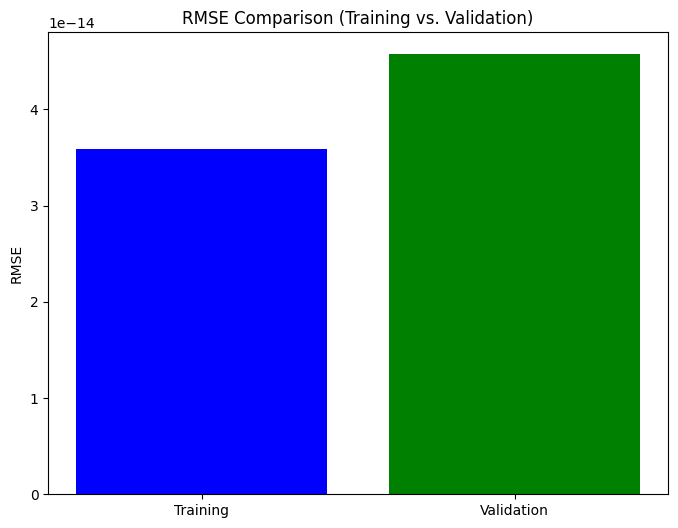

In [47]:
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Assemble the features into a vector column
assembler = VectorAssembler(inputCols=data.columns, outputCol="features",handleInvalid="keep")
assembled_data = assembler.transform(data)

train_ratio = 0.7  # 70% of the data for training
validation_ratio = 0.15  # 15% of the data for validation
test_ratio = 0.15  # 15% of the data for testing

# Split the data into training, validation, and test sets
splits = assembled_data.randomSplit([train_ratio, validation_ratio, test_ratio], seed=123)

# Assign names to the resulting DataFrames
train_data = splits[0]
validation_data = splits[1]
test_data = splits[2]

train_data.cache()
validation_data.cache()
test_data.cache()


lr = LinearRegression(featuresCol="features", labelCol='_c9')

# Step 2: Create a pipeline
pipeline = Pipeline(stages=[lr])

# Step 3: Fit the model to the training data
model = pipeline.fit(train_data)

# Step 4: Make predictions on the test data
predictions = model.transform(test_data)

# Step 5: Evaluate the model on the validation data
validation_predictions = model.transform(validation_data)  # Assuming you have a validation_data DataFrame

# Calculate the accuracy for both training and validation sets
evaluator = RegressionEvaluator(labelCol="_c9", predictionCol="prediction", metricName="rmse")
train_rmse = evaluator.evaluate(model.transform(train_data))
validation_rmse = evaluator.evaluate(validation_predictions)

print("Training RMSE:", train_rmse)
print("Validation RMSE:", validation_rmse)

# Step 7: Plot accuracy
plt.figure(figsize=(8, 6))
plt.bar(["Training", "Validation"], [train_rmse, validation_rmse], color=['blue', 'green'])
plt.title("RMSE Comparison (Training vs. Validation)")
plt.ylabel("RMSE")
plt.show()

In [49]:
evaluator = RegressionEvaluator(labelCol="_c9", predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE):", rmse)


Root Mean Squared Error (RMSE): 3.389357096393811e-14


23/10/07 17:35:50 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB


# Trying some examples

In [50]:
sampled_data = data.sample(withReplacement=False, fraction=0.01, seed=42)
c9_fe=sampled_data.select('_c9')

In [51]:
sampled_data=assembler.transform(sampled_data)



In [52]:
predictions2= model.transform(sampled_data)
combined_df = predictions2.select(expr("prediction AS Prediction"), c9_fe["_c9"].alias("c9_FE"))
combined_df.show()

23/10/07 17:35:56 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB


+------------------+-----+
|        Prediction|c9_FE|
+------------------+-----+
|58.999999999999986|   59|
|             169.0|  169|
|              99.0|   99|
| 80.00000000000001|   80|
|104.00000000000001|  104|
|             350.0|  350|
| 90.00000000000001|   90|
|              54.0|   54|
|              85.0|   85|
|              73.0|   73|
|             109.0|  109|
|141.00000000000003|  141|
| 95.00000000000001|   95|
| 79.00000000000001|   79|
|              61.0|   61|
|             105.0|  105|
| 65.00000000000001|   65|
|             140.0|  140|
|             109.0|  109|
|             160.0|  160|
+------------------+-----+
only showing top 20 rows



# Creating another model with cross validation(Random Forest)

In [65]:
data_rf=data_rf.drop('_c6_Scaled')
data_rf=data_rf.dropna()

In [69]:
assembler = VectorAssembler(inputCols=data.columns, outputCol="features",handleInvalid="keep")
assembled_data = assembler.transform(data)

train_ratio = 0.7  # 70% of the data for training
validation_ratio = 0.15  # 15% of the data for validation
test_ratio = 0.15  # 15% of the data for testing

# Split the data into training, validation, and test sets
splits = assembled_data.randomSplit([train_ratio, validation_ratio, test_ratio], seed=123)

# Assign names to the resulting DataFrames
train_data = splits[0]
validation_data = splits[1]
test_data = splits[2]

train_data.cache()
validation_data.cache()
test_data.cache()

DataFrame[_c2_Scaled: double, _c7_Scaled: double, _c10_Scaled: double, _c11_Scaled: double, _c13_Scaled: double, _c14_Scaled: double, _c15_Scaled: double, _c1_index_Scaled: double, _c3_index_Scaled: double, _c4_index_Scaled: double, _c5_index_Scaled: double, _c8_index_Scaled: double, _c12_index_Scaled: double, _c9: int, features: vector]

23/10/07 17:46:36 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/10/07 17:46:43 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/10/07 17:46:43 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/10/07 17:46:44 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/10/07 17:46:51 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/10/07 17:46:53 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/10/07 17:47:01 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/10/07 17:47:04 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/10/07 17:47:11 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
23/10/07 17:47:13 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
23/10/07 17:47:21 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
23/10/07 17:47:24 WARN DAGScheduler: Broadcasting larg

Training RMSE: 67.70025119433257
Validation RMSE: 184.7731186722655


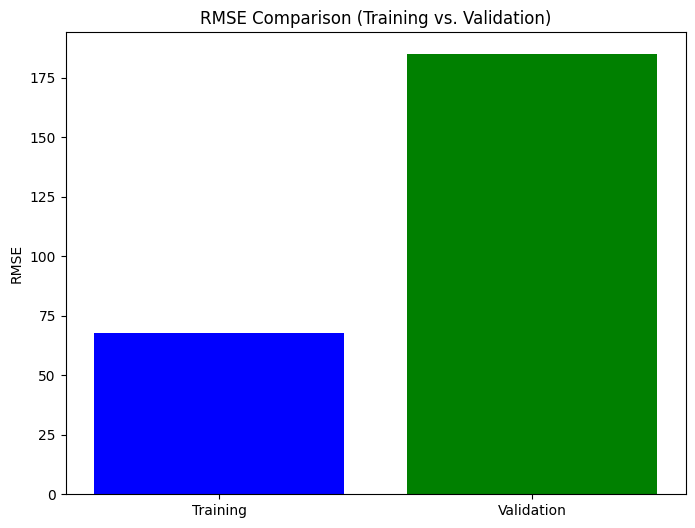

23/10/07 17:49:14 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/10/07 17:49:22 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/10/07 17:49:29 WARN DAGScheduler: Broadcasting large task binary with size 4.6 MiB
23/10/07 17:49:37 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB


In [71]:
import matplotlib.pyplot as plt
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator


rf = RandomForestRegressor(
    featuresCol="features",
    labelCol="_c9",
    numTrees=100,        # Number of decision trees in the forest
    maxDepth=10,         # Maximum depth of each tree
    maxBins=32,          # Maximum number of bins for discretizing continuous features
    minInstancesPerNode=1,  # Minimum number of instances each child must have after split
    minInfoGain=0.0,     # Minimum information gain for a split to be considered
    seed=12345           # Seed for reproducibility
)

# Define the pipeline
pipeline = Pipeline(stages=[rf])

# Fit the model to the training data
model = pipeline.fit(train_data)

# Make predictions on the test data
predictions = model.transform(test_data)

# Evaluate the model on the validation data
validation_predictions = model.transform(validation_data)

# Calculate the RMSE for both training and validation sets
evaluator = RegressionEvaluator(labelCol="_c9", predictionCol="prediction", metricName="rmse")
train_rmse = evaluator.evaluate(model.transform(train_data))
validation_rmse = evaluator.evaluate(validation_predictions)

print("Training RMSE:", train_rmse)
print("Validation RMSE:", validation_rmse)

# Plot RMSE comparison
plt.figure(figsize=(8, 6))
plt.bar(["Training", "Validation"], [train_rmse, validation_rmse], color=['blue', 'green'])
plt.title("RMSE Comparison (Training vs. Validation)")
plt.ylabel("RMSE")
plt.show()


In [72]:
predictions2= model.transform(sampled_data)
combined_df = predictions2.select(expr("prediction AS Prediction"), c9_fe["_c9"].alias("c9_FE"))
combined_df.show()

23/10/07 17:49:44 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB
23/10/07 17:49:45 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


+------------------+-----+
|        Prediction|c9_FE|
+------------------+-----+
| 65.78152224676339|   59|
|168.50625686582873|  169|
| 88.17062266423818|   99|
| 81.40395144448863|   80|
| 123.4906414058175|  104|
|323.30215761437927|  350|
|104.18060604600156|   90|
| 57.54607350373201|   54|
|  83.2526044855227|   85|
| 73.00972330394455|   73|
|102.58065238203693|  109|
|158.90240031179243|  141|
|122.71649397160485|   95|
| 80.87671468268239|   79|
| 62.58929445208693|   61|
|132.24969458021585|  105|
| 67.30992013290687|   65|
| 203.7002327770129|  140|
| 98.82402674614973|  109|
| 157.1512246156121|  160|
+------------------+-----+
only showing top 20 rows



23/10/07 17:49:52 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
23/10/07 17:50:00 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB


# XGBOOST


In [59]:
data_rf=data_rf.drop('_c6_Scaled')
data_rf=data_rf.dropna()
assembler = VectorAssembler(inputCols=data_rf.columns, outputCol="features",handleInvalid="keep")
assembled_data = assembler.transform(data_rf)

train_ratio = 0.7  # 70% of the data for training
validation_ratio = 0.15  # 15% of the data for validation
test_ratio = 0.15  # 15% of the data for testing

# Split the data into training, validation, and test sets
splits = assembled_data.randomSplit([train_ratio, validation_ratio, test_ratio], seed=123)

# Assign names to the resulting DataFrames
train_data = splits[0]
validation_data = splits[1]
test_data = splits[2]

train_data.cache()
validation_data.cache()
test_data.cache()

DataFrame[_c2_Scaled: double, _c7_Scaled: double, _c10_Scaled: double, _c11_Scaled: double, _c13_Scaled: double, _c14_Scaled: double, _c15_Scaled: double, _c1_index: double, _c3_index: double, _c4_index: double, _c5_index: double, _c8_index: double, _c12_index: double, _c9: int, features: vector]

23/10/07 13:20:12 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/10/07 13:20:12 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/10/07 13:20:12 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/10/07 13:20:12 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/10/07 13:20:13 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/10/07 13:20:13 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/10/07 13:20:13 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/10/07 13:20:13 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/10/07 13:20:14 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/10/07 13:20:14 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/10/07 13:20:14 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/10/07 13:20:14 WARN DAGScheduler: Broadcasting larg

Training RMSE: 91.30535338114139
Validation RMSE: 244.1791849503517


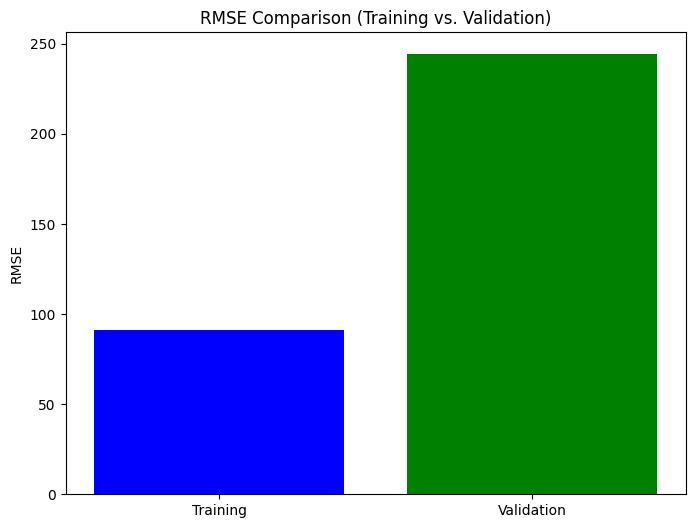

In [337]:
import matplotlib.pyplot as plt
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator

# Define the GBTRegressor model
gbt = GBTRegressor(
    featuresCol="features",
    labelCol="_c9",
    seed=12345
)

# Define the pipeline
pipeline = Pipeline(stages=[gbt])

# Define the parameter grid for hyperparameter tuning
paramGrid = (ParamGridBuilder()
    .addGrid(gbt.maxIter, [10, 20, 30])  # Number of boosting iterations
    .addGrid(gbt.maxDepth, [5, 10, 15])  # Maximum depth of each tree
    .build())

# Define the cross-validator with 5-fold cross-validation
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(labelCol="_c9", predictionCol="prediction", metricName="rmse"),
                          numFolds=5,
                          seed=12345)

# Fit the model to the training data using cross-validation
cv_model = crossval.fit(train_data)

# Make predictions on the test data
predictions = cv_model.transform(test_data)

# Evaluate the model on the validation data
validation_predictions = cv_model.transform(validation_data)

# Calculate the RMSE for both training and validation sets
evaluator = RegressionEvaluator(labelCol="_c9", predictionCol="prediction", metricName="rmse")
train_rmse = evaluator.evaluate(cv_model.transform(train_data))
validation_rmse = evaluator.evaluate(validation_predictions)

print("Training RMSE:", train_rmse)
print("Validation RMSE:", validation_rmse)

# Plot RMSE comparison
plt.figure(figsize=(8, 6))
plt.bar(["Training", "Validation"], [train_rmse, validation_rmse], color=['blue', 'green'])
plt.title("RMSE Comparison (Training vs. Validation)")
plt.ylabel("RMSE")
plt.show()


In [338]:
best_gbt_model = cv_model.bestModel.stages[0]
best_maxIter = best_gbt_model.getMaxIter()
best_maxDepth = best_gbt_model.getMaxDepth()

print("Best maxIter:", best_maxIter)
print("Best maxDepth:", best_maxDepth)

Best maxIter: 10
Best maxDepth: 5


23/10/07 17:50:04 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/10/07 17:50:08 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/10/07 17:50:08 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/10/07 17:50:09 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/10/07 17:50:15 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
23/10/07 17:50:16 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/10/07 17:50:24 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
23/10/07 17:50:24 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/10/07 17:50:32 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/10/07 17:50:32 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
23/10/07 17:50:33 WARN DAGScheduler: Broadcasting large task binary with size 3.7 MiB
23/10/07 17:50:39 WARN DAGScheduler: Broadcasting larg

Training RMSE: 87.28613404852234
Validation RMSE: 246.724821342101


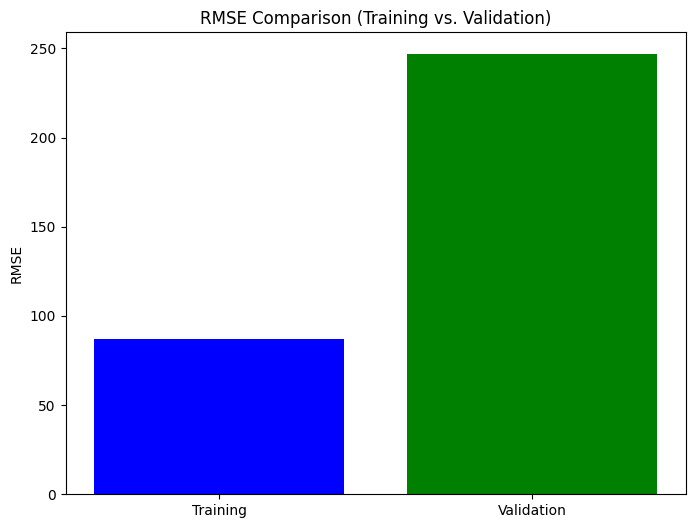

In [73]:
import matplotlib.pyplot as plt
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator

# Define the GBTRegressor model
gbt = GBTRegressor(
    featuresCol="features",
    labelCol="_c9",
    seed=12345
)

# Define the pipeline
pipeline = Pipeline(stages=[gbt])

# Define the parameter grid for hyperparameter tuning
paramGrid = (ParamGridBuilder()
    .addGrid(gbt.maxIter, [10])  # Number of boosting iterations
    .addGrid(gbt.maxDepth, [5,])  # Maximum depth of each tree
    .build())

# Define the cross-validator with 5-fold cross-validation
crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(labelCol="_c9", predictionCol="prediction", metricName="rmse"),
                          numFolds=5,
                          seed=12345)

# Fit the model to the training data using cross-validation
cv_model = crossval.fit(train_data)

# Make predictions on the test data
predictions = cv_model.transform(test_data)

# Evaluate the model on the validation data
validation_predictions = cv_model.transform(validation_data)

# Calculate the RMSE for both training and validation sets
evaluator = RegressionEvaluator(labelCol="_c9", predictionCol="prediction", metricName="rmse")
train_rmse = evaluator.evaluate(cv_model.transform(train_data))
validation_rmse = evaluator.evaluate(validation_predictions)

print("Training RMSE:", train_rmse)
print("Validation RMSE:", validation_rmse)

# Plot RMSE comparison
plt.figure(figsize=(8, 6))
plt.bar(["Training", "Validation"], [train_rmse, validation_rmse], color=['blue', 'green'])
plt.title("RMSE Comparison (Training vs. Validation)")
plt.ylabel("RMSE")
plt.show()


In [74]:
predictions2= model.transform(sampled_data)
combined_df = predictions2.select(expr("prediction AS Prediction"), c9_fe["_c9"].alias("c9_FE"))
combined_df.show()

+------------------+-----+
|        Prediction|c9_FE|
+------------------+-----+
| 65.78152224676339|   59|
|168.50625686582873|  169|
| 88.17062266423818|   99|
| 81.40395144448863|   80|
| 123.4906414058175|  104|
|323.30215761437927|  350|
|104.18060604600156|   90|
| 57.54607350373201|   54|
|  83.2526044855227|   85|
| 73.00972330394455|   73|
|102.58065238203693|  109|
|158.90240031179243|  141|
|122.71649397160485|   95|
| 80.87671468268239|   79|
| 62.58929445208693|   61|
|132.24969458021585|  105|
| 67.30992013290687|   65|
| 203.7002327770129|  140|
| 98.82402674614973|  109|
| 157.1512246156121|  160|
+------------------+-----+
only showing top 20 rows



23/10/07 17:55:45 WARN DAGScheduler: Broadcasting large task binary with size 3.6 MiB


In [34]:
from pyspark.ml.regression import MultilayerPerceptronRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt

# Define the feature assembler
assembler = VectorAssembler(inputCols=data.columns, outputCol="features", handleInvalid="keep")
assembled_data = assembler.transform(data)

# Split the data into training, validation, and test sets
train_ratio = 0.7
validation_ratio = 0.15
test_ratio = 0.15
splits = assembled_data.randomSplit([train_ratio, validation_ratio, test_ratio], seed=123)
train_data, validation_data, test_data = splits

# Cache the datasets
train_data.cache()
validation_data.cache()
test_data.cache()



ImportError: cannot import name 'MultilayerPerceptronRegressor' from 'pyspark.ml.regression' (/opt/conda/lib/python3.10/site-packages/pyspark/ml/regression.py)

In [ ]:

# Define the Multilayer Perceptron Regressor
layers = [len(data.columns) - 1, 64, 32, 1]  # Specify the layers for the neural network
mlp = MultilayerPerceptronRegressor(featuresCol="features", labelCol="_c9", layers=layers, seed=12345)

# Define the pipeline
pipeline = Pipeline(stages=[mlp])

# Fit the model to the training data
model = pipeline.fit(train_data)

# Make predictions on the test data
predictions = model.transform(test_data)

# Evaluate the model on the validation data
validation_predictions = model.transform(validation_data)

# Calculate the RMSE for both training and validation sets
evaluator = RegressionEvaluator(labelCol="_c9", predictionCol="prediction", metricName="rmse")
train_rmse = evaluator.evaluate(model.transform(train_data))
validation_rmse = evaluator.evaluate(validation_predictions)

print("Training RMSE:", train_rmse)
print("Validation RMSE:", validation_rmse)

# Plot RMSE comparison
plt.figure(figsize=(8, 6))
plt.bar(["Training", "Validation"], [train_rmse, validation_rmse], color=['blue', 'green'])
plt.title("RMSE Comparison (Training vs. Validation)")
plt.ylabel("RMSE")
plt.show()

In [33]:
import pyspark
print(pyspark.__version__)


3.5.0
